# 第6章 数据加载、存储与文件格式

**访问数据**是使用本书所介绍的这些工具的第一步。这里会着重介绍**pandas**的__数据输入与输出__，虽然别的库中也有不少以此为目的的工具。

**输入输出**通常可以划分为__几个大类__：读取**文本文件**和其他更高效的__磁盘存储格式__，加载**数据库**中的数据，利用__Web API__操作**网络资源**。

# 1.读写文本格式的数据

pandas提供了一些用于将**表格型数据**读取为__DataFrame对象__的函数。表6-1对它们进行了总结，其中**read_csv**和__read_table__可能会是你今后**用得最多**的。
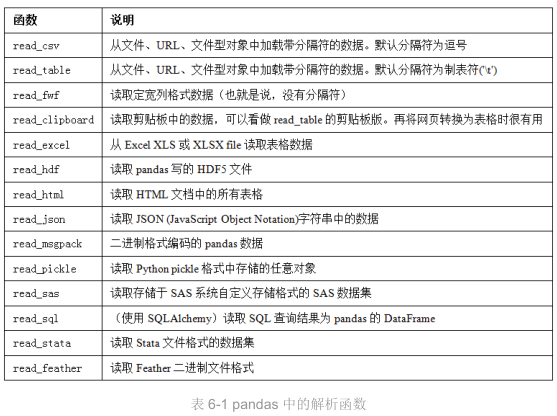

这里将大致介绍一下**这些函数**在将__文本数据__转换为**DataFrame**时所用到的一些__技术__。**这些函数的选项**可以划分为以下__几个大类__：
- 索引：将一个或多个列当做返回的DataFrame处理，以及是否从文件、用户__获取列名__。
- 类型推断和数据转换：包括用户定义值的__转换__、和自定义的__缺失值__标记列表等。
- 日期解析：包括__组合__功能，比如将分散在__多个列__中的**日期时间信息**组合成结果中的__单个列__。
- 迭代：支持对大文件进行逐块迭代。
- 不规整数据问题：__跳过__一些行、页脚、注释或其他一些不重要的东西(比如由成千上万个逗号隔开的数值数据)。

因为工作中**实际**碰到的数据可能__十分混乱__，一些**数据加载函数**(尤其是__read_csv__)的**选项**逐渐__变得复杂__起来。面对不同的参数，感到头痛很正常(read_csv有__超过50个参数__)。__pandas文档__有这些参数的例子，如果你感到阅读某个文件很难，可以通过相似的足够多的例子找到正确的参数。

- 其中一些函数，比如**pandas.read_csv**，有__类型推断__功能，因为__列数据的类型__不属于**数据类型**。__也就是说__，你不需要指定列的类型到底是数值、整数、布尔值，还是字符串。
- __其它的数据格式__，如 HDF5、Feather 和 msgpack，会**在格式中存储数据类型**。

__日期__和**其他自定义类型**的处理需要多花点工夫才行。首先我们来看一个以__逗号__分隔的**(CSV)文本文件**：

In [13]:
! type examples\ex1.csv

a,b,c,d,message
1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo


笔记：这里，用的是__Unix__的**cat shell命令**将__文件的原始内容__打印到**屏幕**上。如果你用的是**Windows**，你可以使用**type**达到同样的效果。(如上一行的代码所示，注意斜杠/和反斜杠\的使用)

- 由于该文件以**逗号**分隔，所以我们可以使用__read_csv__将其读入一个**DataFrame**：

In [1]:
import pandas as pd

In [16]:
df = pd.read_csv('examples/ex1.csv')

df

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


我们还可以使用__read_table__，并指定**分隔符**：(因为read_table的默认分隔符是制表符\t)

In [17]:
pd.read_table('examples/ex1.csv', sep=',')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


- 并不是所有文件都有__标题行__。看看下面这个文件：

In [19]:
! type examples\ex2.csv

1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo


读入该文件的办法有__两个__:
- 可以让pandas为其分配__默认的列名__
- 也可以__自定义列名__

In [21]:
pd.read_csv('examples/ex2.csv', header=None)

,0,1,2,3,4
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [22]:
pd.read_csv('examples/ex2.csv', names=['a', 'b', 'c', 'd', 'message'])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


假设你希望将message列做成__DataFrame__的**索引**:
- 可以明确表示要将__该列__放到__索引4__的位置上
- 也可以通过**index_col参数**指定"message"：

In [2]:
# 明确表示要将该列放到索引4的位置上
names=['a', 'b', 'c', 'd', 'message']

pd.read_csv('examples/ex2.csv', names=names, index_col=4)

,a,b,c,d
message,,,,
hello,1,2,3,4
world,5,6,7,8
foo,9,10,11,12


In [3]:
# 通过index_col参数指定"message"

names=['a', 'b', 'c', 'd', 'message']

pd.read_csv('examples/ex2.csv', names=names, index_col='message')

,a,b,c,d
message,,,,
hello,1,2,3,4
world,5,6,7,8
foo,9,10,11,12


如果希望将__多个列__做成一个**层次化索引**，只需传入由__列编号或列名__组成的**列表**即可：

In [25]:
! type examples\csv_mindex.csv

key1,key2,value1,value2
one,a,1,2
one,b,3,4
one,c,5,6
one,d,7,8
two,a,9,10
two,b,11,12
two,c,13,14
two,d,15,16


In [27]:
parsed = pd.read_csv('examples/csv_mindex.csv', index_col=['key1','key2'])

parsed

value1  value2
key1 key2                
one  a          1       2
     b          3       4
     c          5       6
     d          7       8
two  a          9      10
     b         11      12
     c         13      14
     d         15      16

- 有些情况下，有些表格可能__不是__用**固定的分隔符**去分隔字段的(比如__空白符或其他模式__)。

看看下面这个文本文件：

In [28]:
list(open('examples/ex3.txt'))

['            A         B         C\n',
 'aaa -0.264438 -1.026059 -0.619500\n',
 'bbb  0.927272  0.302904 -0.032399\n',
 'ccc -0.264273 -0.386314 -0.217601\n',
 'ddd -0.871858 -0.348382  1.100491\n']

虽然可以__手动__对数据进行**规整**，这里的字段是被__数量不同__的**空白字符**间隔开的。这种情况下，你可以传递一个**正则表达式**作为read_table 的分隔符。可以用正则表达式表达为 **\s+**，于是有：

关于正则表达式的注释：
- \s：匹配任何__空白字符__，包括空格、制表符、换页符等等。等价于 [ \f\n\r\t\v]
- \S：匹配任何__非空白字符__。等价于 [^ \f\n\r\t\v]
- *：匹配__0个__或多个的表达式
- +：匹配__1个__或多个的表达式

In [31]:
result = pd.read_table('examples/ex3.txt', sep='\s+')

result

,A,B,C
aaa,-0.264438,-1.026059,-0.619500
bbb,0.927272,0.302904,-0.032399
ccc,-0.264273,-0.386314,-0.217601
ddd,-0.871858,-0.348382,1.100491


这里，由于__列名__比**数据列**的数量少，所以read_table**推断第一列**应该是DataFrame的__索引__。

- 这些**解析器函数**还有许多__参数__可以帮助你处理各种各样的__异形文件格式__(表6-2列出了一些)。

比如说，你可以用**skiprows**跳过下面这个文件的第一行、第三行和第四行：

In [33]:
! type examples\ex4.csv

# hey!
a,b,c,d,message
# just wanted to make things more difficult for you
# who reads CSV files with computers, anyway?
1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo


In [34]:
pd.read_csv('examples/ex4.csv', skiprows=[0, 2, 3])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


- __缺失值处理__是**文件解析**任务中的一个重要组成部分。缺失数据经常是要么__没有(空字符串)__，要么用__某个标记值__表示。__默认__情况下，pandas会用__一组经常出现的标记值__进行识别，比如**NA及NULL**：

In [35]:
! type examples\ex5.csv

something,a,b,c,d,message
one,1,2,3,4,NA
two,5,6,,8,world
three,9,10,11,12,foo


In [36]:
result = pd.read_csv('examples/ex5.csv')

result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


In [37]:
pd.isnull(result)

,something,a,b,c,d,message
0,False,False,False,False,False,True
1,False,False,False,True,False,False
2,False,False,False,False,False,False


na_values:指定某些字符串表示缺失值。比如na_values=['None', 'null']，表示将这些字符串作为NaN。

__na_values__可以用一个__列表或集合的字符串__表示**缺失值**：

In [38]:
result = pd.read_csv('examples/ex5.csv', na_values=['NULL'])

result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


利用**字典**，__各列__可以使用__不同的NA标记值__：

In [39]:
sentinels = {'message':['foo','NA'], 'something':['two']}

pd.read_csv('examples/ex5.csv', na_values=sentinels)

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,NaN,5,6,NaN,8,world
2,three,9,10,11.0,12,NaN


表6-2列出了__pandas.read_csv和pandas.read_table__函数常用的__选项__。
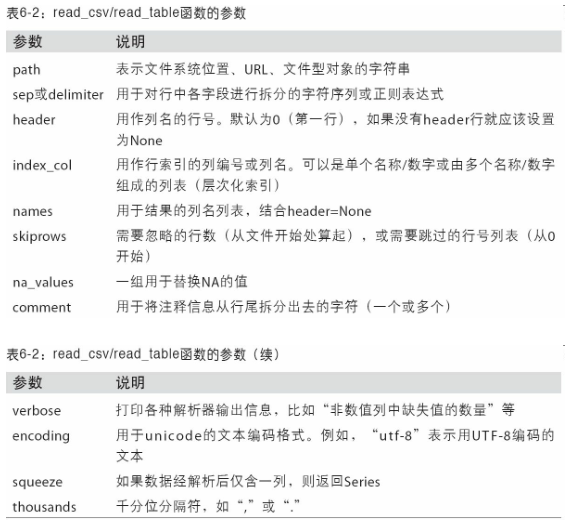

## 1.1 逐块读取文本文件

在处理__很大__的文件时，或找出__大文件中的参数集__以便于后续处理时，你可能只想读取文件的__一小部分__或__逐块__对文件进行__迭代__。

在看大文件之前，我们先设置__pandas显示__地__更紧__些：

In [40]:
pd.options.display.max_rows = 10

然后有：

In [41]:
result = pd.read_csv('examples/ex6.csv')

result

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q
...,...,...,...,...,...
9995,2.311896,-0.417070,-1.409599,-0.515821,L
9996,-0.479893,-0.650419,0.745152,-0.646038,E
9997,0.523331,0.787112,0.486066,1.093156,K
9998,-0.362559,0.598894,-1.843201,0.887292,G


- 如果只想__读取几行__(**避免**读取__整个文件__)，通过__nrows__进行指定即可：

In [42]:
pd.read_csv('examples/ex6.csv', nrows=5)

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q


- 要__逐块读取__文件，可以指定__chunksize(行数)__：

In [43]:
chunker = pd.read_csv('examples/ex6.csv', chunksize=1000)

chunker

- read_csv所返回的这个__TextParser对象__使你可以根据__chunksize__对文件进行__逐块迭代__。
- TextParser还有一个__get_chunk__方法，它使你可以读取__任意大小的块__。

比如说，我们可以迭代处理ex6.csv，将__值计数__聚合到__"key"列__中，如下所示：

In [44]:
tot = pd.Series([])

for piece in chunker:
    tot = tot.add(piece['key'].value_counts(), fill_value=0)
    
tot.sort_values(ascending=False)

E    368.0
X    364.0
L    346.0
O    343.0
Q    340.0
     ...  
5    157.0
2    152.0
0    151.0
9    150.0
1    146.0
Length: 36, dtype: float64

然后有：

In [45]:
tot[:10]

0    151.0
1    146.0
2    152.0
3    162.0
4    171.0
5    157.0
6    166.0
7    164.0
8    162.0
9    150.0
dtype: float64

## 1.2 将数据写出到文本格式

### DataFrame

数据也可以被**输出**为**分隔符格式**的__文本__。我们再来看看之前读过的一个**CSV文件**：

In [46]:
data = pd.read_csv('examples/ex5.csv')
data

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


- 利用DataFrame的__to_csv方法__，我们可以将数据写到一个以__逗号__分隔的文件中：

In [47]:
data.to_csv('examples/out.csv')

In [49]:
! type examples\out.csv

,something,a,b,c,d,message
0,one,1,2,3.0,4,
1,two,5,6,,8,world
2,three,9,10,11.0,12,foo


- 当然，还可以使用__其他分隔符__(由于这里直接__写出到sys.stdout__，所以仅仅是__打印出文本结果__而已)：

注释：在python中调用print时，事实上调用了sys.stdout.write(obj+'\n')，print将需要的内容打印到控制台，然后追加一个换行符。以下两行代码等价：
```
sys.stdout.write('hello' + '\n')
print('hello')
```

In [50]:
import sys
data.to_csv(sys.stdout, sep='|')

|something|a|b|c|d|message
0|one|1|2|3.0|4|
1|two|5|6||8|world
2|three|9|10|11.0|12|foo


- __缺失值__在__输出结果__中会被表示为__空字符串__。你可能希望将其表示为__别的标记值__：

In [51]:
data.to_csv(sys.stdout, na_rep='NULL')

,something,a,b,c,d,message
0,one,1,2,3.0,4,NULL
1,two,5,6,NULL,8,world
2,three,9,10,11.0,12,foo


- 如果没有设置__其他选项__，则会写出__行和列的标签__。当然，它们也都可以被__禁用__：

In [52]:
data.to_csv(sys.stdout, index=False, header=False)

one,1,2,3.0,4,
two,5,6,,8,world
three,9,10,11.0,12,foo


- 此外，你还可以只写出__一部分的列__，并以你__指定的顺序__排列：

In [54]:
data.to_csv(sys.stdout, index=False, columns=['a', 'b', 'c'])

a,b,c
1,2,3.0
5,6,
9,10,11.0


### Series

Series也有一个__to_csv方法__:

In [57]:
import numpy as np

dates = pd.date_range('1/1/2000', periods=7)

ts = pd.Series(np.arange(7), index=dates)

ts.to_csv('examples/tseries.csv')

In [58]:
! type examples\tseries.csv

2000-01-01,0
2000-01-02,1
2000-01-03,2
2000-01-04,3
2000-01-05,4
2000-01-06,5
2000-01-07,6


## 1.3 处理分隔符格式

__大部分__存储在__磁盘__上的__表格型数据__都能用__pandas.read_table__进行__加载__。

然而，有时还是需要做一些__手工处理__。由于接收到含有__畸形行__的文件而使
__read_table出毛病__的情况并不少见。为了说明这些__基本工具__，看看下面这个简
单的__CSV文件__：

In [59]:
! type examples\ex7.csv

"a","b","c"
"1","2","3"
"1","2","3"


- 对于__任何单字符分隔符__文件，可以直接使用__Python内置__的__csv模块__。将__任意已打开的文件__或__文件型的对象__传给__csv.reader__：

In [70]:
import csv

f = open('examples/ex7.csv')

reader = csv.reader(f)

对这个__reader__进行__迭代__将会为__每行__产生__一个元组__(并__移除了所有的引号__)：

In [61]:
for line in reader:
    print(line)

['a', 'b', 'c']
['1', '2', '3']
['1', '2', '3']


现在，为了使__数据格式__合乎要求，你需要对其做一些__整理工作__。

我们一步一步来做。首先，__读取__文件到一个__多行的列表__中：

In [62]:
with open('examples/ex7.csv') as f:
    lines = list(csv.reader(f))

然后，我们将这些**行**分为__标题行__和__数据行__：

In [63]:
header, values = lines[0], lines[1:]

values

[['1', '2', '3'], ['1', '2', '3']]

然后，我们可以用__字典构造式和zip(*values)__，(后者将__行转置为列__)，创建__数据列__的__字典__：

In [67]:
for v in zip(*values):
    print(v)

('1', '1')
('2', '2')
('3', '3')


In [68]:
data_dict = {h: v for h, v in zip(header, zip(*values))}

data_dict

{'a': ('1', '1'), 'b': ('2', '2'), 'c': ('3', '3')}

- __CSV文件__的__形式__有很多。只需定义__csv.Dialect的一个子类__即可定义出__新格式__(如专门的分隔符、字符串引用约定、行结束符等)：

In [72]:
class my_dialect(csv.Dialect):
    lineterminator = '\n'
    delimiter = ';'
    quotechar = '"'
    quoting = csv.QUOTE_MINIMAL

f = open('examples/ex7.csv')

reader = csv.reader(f, dialect=my_dialect)

- 各个__CSV语支__的__参数__也可以__关键字__的形式提供给__csv.reader__，而__无需定义子类__：

In [73]:
reader = csv.reader(f, delimiter='|')

可用的选项(__csv.Dialect的属性__)及其__功能__如表6-3所示。
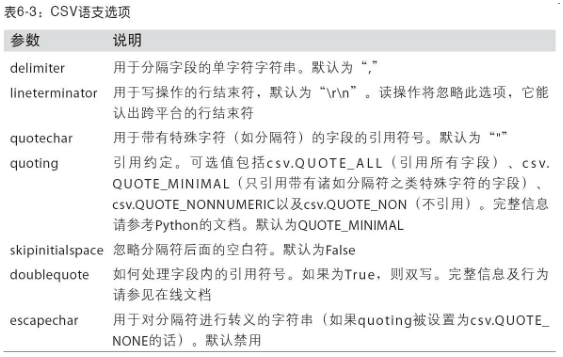

- 笔记：对于那些使用__复杂分隔符或多字符分隔符__的文件，__csv模块__就__无能为力__了。这种情况下，你就只能使用__字符串的split方法__或__正则表达式方法re.split__进行__行拆分__和其他__整理__工作了。

- 要__手工输出__分隔符文件，你可以使用__csv.writer__。它接受一个__已打开且可写的文件对象__以及跟csv.reader__相同__的那些__语支和格式化选项__：

In [74]:
with open('mydata.csv', 'w') as f:
    writer = csv.writer(f, dialect=my_dialect)
    writer.writerow(('one', 'two', 'three'))
    writer.writerow(('1', '2', '3')) 
    writer.writerow(('4', '5', '6')) 
    writer.writerow(('7', '8', '9'))

In [75]:
! type mydata.csv

one;two;three
1;2;3
4;5;6
7;8;9


# 1.4 JSON数据

JSON(JavaScript Object Notation 的简称)已经成为通过__HTTP请求__在__Web浏览器__和**其他应用程序**之间__发送数据__的**标准格式**之一。它是一种比__表格型文本格式__(如__CSV__)**灵活**得多的数据格式。下面是一个例子：

In [82]:
obj = """ 
{"name": "Wes", 
 "places_lived": ["United States", "Spain", "Germany"], 
 "pet": null, 
 "siblings": [{"name": "Scott", "age": 30, "pets": ["Zeus", "Zuko"]}, 
              {"name": "Katie", "age": 38, 
               "pets": ["Sixes", "Stache", "Cisco"]}] 
} 
"""

除__其空值null__和一些其他的__细微差别__(如__列表末尾__不允许存在__多余的逗号__)之外，JSON非常接近于__有效的Python代码__。

__基本类型__有对象(字典)、数组(列表)、字符串、数值、布尔值以及 null。__对象__中所有的**键**都必须是__字符串__。

- 许多__Python库__都可以__读写JSON数据__。这里将使用__json__，因为它是构建于__Python标准库__中的。通过__json.loads__即可将__JSON字符串__转换成 __Python形式__：

In [86]:
import json

result = json.loads(obj)
result

{'name': 'Wes',
 'places_lived': ['United States', 'Spain', 'Germany'],
 'pet': None,
 'siblings': [{'name': 'Scott', 'age': 30, 'pets': ['Zeus', 'Zuko']},
  {'name': 'Katie', 'age': 38, 'pets': ['Sixes', 'Stache', 'Cisco']}]}

- __json.dumps__则将__Python对象__转换成__JSON格式__：

In [87]:
asjson = json.dumps(result)

asjson

'{"name": "Wes", "places_lived": ["United States", "Spain", "Germany"], "pet": null, "siblings": [{"name": "Scott", "age": 30, "pets": ["Zeus", "Zuko"]}, {"name": "Katie", "age": 38, "pets": ["Sixes", "Stache", "Cisco"]}]}'

如何将__(一个或一组)JSON对象__转换为__DataFrame__或其他便于分析的__数据结构__就由你决定了。最简单方便的方式是:向__DataFrame构造器__传入一个__字典的列表__(就是原先的__JSON对象__)，并选取数据字段的__子集__：

In [89]:
siblings = pd.DataFrame(result['siblings'], columns=['name', 'age'])

siblings

,name,age
0,Scott,30
1,Katie,38


- __pandas.read_json__可以__自动__将__特别格式__的__JSON数据集__转换为__Series或DataFrame__。例如：

In [91]:
# 字典的列表
! type examples\example.json

[{"a": 1, "b": 2, "c": 3},
 {"a": 4, "b": 5, "c": 6},
 {"a": 7, "b": 8, "c": 9}]


pandas.read_json的__默认选项__假设__JSON数组__中的__每个对象__是表格中的__一行__：

In [92]:
data = pd.read_json('examples/example.json')

data

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9


第7章中关于USDA Food Database的那个例子__进一步讲解__了__JSON数据__的__读取和处理__(包括__嵌套记录__)。

- 如果你需要将数据从pandas**输出到JSON**，可以使用__to_json方法__：

In [93]:
print(data.to_json())

{"a":{"0":1,"1":4,"2":7},"b":{"0":2,"1":5,"2":8},"c":{"0":3,"1":6,"2":9}}


In [94]:
print(data.to_json(orient='records'))

[{"a":1,"b":2,"c":3},{"a":4,"b":5,"c":6},{"a":7,"b":8,"c":9}]


## 1.5 XML和HTML：Web信息收集

Python有许多可以__读写常见的HTML和XML格式数据__的__库__，包括__lxml、Beautiful Soup和html5lib__:
- __lxml__的__速度__比较快;
- 但__其它的库__处理__有误的HTML或XML文件__更好。

### 1.5.1 HTML：pd.read_html

- pandas有一个__内置__的功能，__read_html__，它可以使用__lxml和 Beautiful Soup__自动将__HTML文件__中的__表格__解析为__DataFrame对象__。

为了进行展示，从美国联邦存款保险公司下载了一个__HTML文件__(pandas文档中也使用过)，它记录了银行倒闭的情况。首先，你需要安装__read_html用到的库__：
```
conda install lxml 
pip install beautifulsoup4 html5lib
```
如果你用的不是conda，可以使用pip install lxml。

__pandas.read_html__有一些__选项__，__默认__条件下，它会**搜索、尝试解析\<!-- table !-->标签**内的的__表格数据__。结果是一个__列表__的__DataFrame对象__：

In [95]:
tables = pd.read_html('examples/fdic_failed_bank_list.html')

In [102]:
tables

[                             Bank Name             City  ST   CERT  \
 0                          Allied Bank         Mulberry  AR     91   
 1         The Woodbury Banking Company         Woodbury  GA  11297   
 2               First CornerStone Bank  King of Prussia  PA  35312   
 3                   Trust Company Bank          Memphis  TN   9956   
 4           North Milwaukee State Bank        Milwaukee  WI  20364   
 ..                                 ...              ...  ..    ...   
 542                 Superior Bank, FSB         Hinsdale  IL  32646   
 543                Malta National Bank            Malta  OH   6629   
 544    First Alliance Bank & Trust Co.       Manchester  NH  34264   
 545  National State Bank of Metropolis       Metropolis  IL   3815   
 546                   Bank of Honolulu         Honolulu  HI  21029   
 
                    Acquiring Institution        Closing Date  \
 0                           Today's Bank  September 23, 2016   
 1              

In [98]:
tables.shape

AttributeError: 'list' object has no attribute 'shape'

In [96]:
len(tables)

1

In [100]:
failtures = tables[0]

In [101]:
failtures.head()

,Bank Name,City,ST,CERT,Acquiring Institution,Closing Date,Updated Date
0,Allied Bank,Mulberry,AR,91,Today's Bank,"September 23, 2016","November 17, 2016"
1,The Woodbury Banking Company,Woodbury,GA,11297,United Bank,"August 19, 2016","November 17, 2016"
2,First CornerStone Bank,King of Prussia,PA,35312,First-Citizens Bank & Trust Company,"May 6, 2016","September 6, 2016"
3,Trust Company Bank,Memphis,TN,9956,The Bank of Fayette County,"April 29, 2016","September 6, 2016"
4,North Milwaukee State Bank,Milwaukee,WI,20364,First-Citizens Bank & Trust Company,"March 11, 2016","June 16, 2016"


因为failures有__许多列__，pandas插入了一个**换行符\\ **。(但是这里展示得开，所以没有加换行符)

这里，我们可以做一些__数据清洗和分析__(后面章节会__进一步讲解__)，比如计算按年份计算倒闭的银行数：

In [103]:
close_timestamp = pd.to_datetime(failtures['Closing Date'])

close_timestamp

0     2016-09-23
1     2016-08-19
2     2016-05-06
3     2016-04-29
4     2016-03-11
         ...    
542   2001-07-27
543   2001-05-03
544   2001-02-02
545   2000-12-14
546   2000-10-13
Name: Closing Date, Length: 547, dtype: datetime64[ns]

In [106]:
close_timestamp.dt.year.value_counts()

2010    157
2009    140
2011     92
2012     51
2008     25
       ... 
2004      4
2001      4
2007      3
2003      3
2000      2
Name: Closing Date, Length: 15, dtype: int64

### 1.5.2 lxml.objectify解析XML

XML(Extensible Markup Language)是另一种常见的支持__分层、嵌套数据__以及__元数据__的__结构化数据格式__。本书所使用的这些文件实际上来自于一个很大的XML文档。

- 前面，介绍了__pandas.read_html__函数，它可以使用__lxml或Beautiful Soup__从__HTML__解析数据。XML和HTML的__结构很相似__，但__XML更为通用__。这里，用一个例子演示如何利用__lxml__从__XML格式解析数据__。

纽约大都会运输署发布了一些有关其公交和列车服务的数据资料(http://www.mta.info/developers/download.html)。 

这里，我们将看看包含在__一组XML文件__中的__运行情况数据__。__每项列车或公交服务__都有__各自的文件__(如Metro-North Railroad的文件Performance_MNR.xml)，其中__每条XML记录__就是一条__月度数据__，如下所示：

<INDICATOR> 
  <INDICATOR_SEQ>373889</INDICATOR_SEQ> 
  <PARENT_SEQ></PARENT_SEQ> 
  <AGENCY_NAME>Metro-North Railroad</AGENCY_NAME> 
  <INDICATOR_NAME>Escalator Availability</INDICATOR_NAME> 
  <DESCRIPTION>Percent of the time that escalators are operational 
  systemwide. The availability rate is based on physical observations 
performed 
  the morning of regular business days only. This is a new indicator 
the agency 
  began reporting in 2009.</DESCRIPTION> 
  <PERIOD_YEAR>2011</PERIOD_YEAR> 
  <PERIOD_MONTH>12</PERIOD_MONTH> 
  <CATEGORY>Service Indicators</CATEGORY> 
  <FREQUENCY>M</FREQUENCY> 
  <DESIRED_CHANGE>U</DESIRED_CHANGE> 
  <INDICATOR_UNIT>%</INDICATOR_UNIT> 
  <DECIMAL_PLACES>1</DECIMAL_PLACES> 
  <YTD_TARGET>97.00</YTD_TARGET> 
  <YTD_ACTUAL></YTD_ACTUAL> 
  <MONTHLY_TARGET>97.00</MONTHLY_TARGET> 
  <MONTHLY_ACTUAL></MONTHLY_ACTUAL> 
</INDICATOR>

- 我们先用__lxml.objectify解析__该文件，然后通过__getroot__得到该XML文件的__根节点的引用__：

In [108]:
from lxml import objectify

In [123]:
path = 'pydata-book-2nd-edition/datasets/mta_perf/Performance_MNR.xml'

parsed = objectify.parse(open(path))

root = parsed.getroot()

root

<Element PERFORMANCE at 0x21d34997788>

- __root.INDICATOR__返回一个用于产生**各个<!--INDICATOR !-->XML元素**的__生成器__。

对于__每条记录__，我们可以用__标记名__(如 YTD_ACTUAL)和__数据值__填充一个__字典__(__排除__几个标记)：

In [125]:
data = []

skip_fields = ['PARENT_SEQ', 'INDICATOR_SEQ', 'DESIRED_CHANGE', 'DECIMAL_PLACES']

for elt in root.INDICATOR:
    el_data = {}
    for child in elt.getchildren():
        if child.tag in skip_fields:
            continue
        el_data[child.tag] = child.pyval
    data.append(el_data)

In [127]:
# data

- 最后，将__这组字典__转换为一个__DataFrame__：

In [128]:
perf = pd.DataFrame(data)

perf.head()

,AGENCY_NAME,CATEGORY,DESCRIPTION,FREQUENCY,INDICATOR_NAME,INDICATOR_UNIT,MONTHLY_ACTUAL,MONTHLY_TARGET,PERIOD_MONTH,PERIOD_YEAR,YTD_ACTUAL,YTD_TARGET
0,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,96.9,95,1,2008,96.9,95
1,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,95,95,2,2008,96,95
2,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,96.9,95,3,2008,96.3,95
3,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,98.3,95,4,2008,96.8,95
4,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,95.8,95,5,2008,96.6,95


__XML数据__可以比本例__复杂__得多。**每个标记**都可以有__元数据__。

- 看看下面这个__HTML的链接标签__(它也算是一段__有效的XML__)：

In [129]:
from io import StringIO

In [130]:
tag = '<a href="http://www.google.com">Google</a>'

root = objectify.parse(StringIO(tag)).getroot()

现在就可以访问__标签或链接文本__中的__任何字段__了(如href)：

In [131]:
root

<Element a at 0x21d34bb2fc8>

In [132]:
root.get('href')

'http://www.google.com'

In [134]:
root.text

'Google'

# 2.二进制数据格式

- 实现数据的__高效二进制格式存储__最简单的办法之一是使用__Python内置的pickle序列化__。

- __pandas对象__都有一个用于将数据以__pickle格式__保存到__磁盘__上的__to_pickle方法__：

In [135]:
frame = pd.read_csv('examples/ex1.csv')

frame

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [137]:
frame.to_pickle('examples/frame_pickle')

读取：

- 你可以通过__pickle__直接读取__被pickle化__的数据，
- 或是使用__更为方便__的__pandas.read_pickle__：

In [138]:
pd.read_pickle('examples/frame_pickle')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


注意：pickle仅建议用于__短期存储格式__。其原因是很难保证__该格式永远__是__稳定__的；今天__pickle的对象__可能无法被__后续版本的库unpickle_来。

虽然作者尽力保证这种事情__不会发生__在pandas中，但是今后的某个时候说不定还是得“__打破__”该pickle格式。

pandas内置支持两个__二进制数据格式__：__HDF5和MessagePack__。

下一节，会给出几个__HDF5__的例子，但建议你尝试下__不同的文件格式__，看看它们的__速度__以及__是否适合__你的分析工作。

__pandas或NumPy数据__的__其它存储格式__有：
- bcolz：一种__可压缩__的__列存储二进制格式__，基于__Blosc压缩库__。
- Feather：作者与R语言社区的Hadley Wickham设计的一种__跨语言__的__列存储文件格式__。Feather使用了__Apache Arrow__的__列式内存格式__。

## 2.1 使用HDF5格式

HDF5是一种存储__大规模科学数组数据__的__非常好__的__文件格式__。它可以被作为__C库__，带有__许多语言__的__接口__，如 Java、Python 和 MATLAB 等。

HDF5中的HDF指的是__层次型数据格式__(hierarchical data format)。__每个HDF5文件__都含有一个__文件系统式__的__节点结构__，它使你能够存储__多个数据集__并支持__元数据__。

与其他__简单格式__相比，HDF5支持__多种压缩器__的__即时压缩__，还能__更高效__地存储__重复模式数据__。对于那些__非常大__的无法__直接放入内存__的数据集，HDF5就是__不错的选择__，因为它可以__高效__地__分块读写__。

- 虽然可以用__PyTables或h5py库__直接访问HDF5文件
- pandas提供了__更为高级的接口__，可以__简化存储Series和DataFrame对象__。__HDFStore类__可以像__字典__一样，处理__低级的细节__：

In [141]:
frame = pd.DataFrame({'a': np.random.randn(100)})

store = pd.HDFStore('mydata.h5')

store['obj1'] = frame

store['obj1_col'] = frame['a']

In [142]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: mydata.h5

- __HDF5文件__中的__对象__可以通过与__字典__一样的__API__进行获取：

In [143]:
store['obj1']

,a
0,1.431347
1,-0.575682
2,-1.767802
3,0.089482
4,-0.792282
...,...
95,1.603311
96,-0.619032
97,-1.075505
98,0.868274


- __HDFStore__支持__两种存储模式(format)__，'fixed'和'table'。__后者__通常会__更慢__，但是支持使用__特殊语法__进行__查询__操作：

In [144]:
store.put('obj2', frame, format='table')

In [145]:
store.select('obj2', where=['index >= 10 and index <= 15'])

,a
10,0.272557
11,0.430027
12,-0.148802
13,0.416839
14,-0.602082
15,0.030873


In [150]:
store.close()

- __put__是__store['obj2'] = frame__方法的__显示版本__，允许我们设置__其它的选项__，比如__格式__。

- __pandas.read_hdf函数__可以__快捷使用__这些工具：

In [148]:
frame.to_hdf('mydata.h5', 'obj3', format='table')

In [157]:
# pd.read_hdf('mydata.h5', 'obj3',  where=['index < 5']) # 出错

笔记：如果你要处理的数据位于__远程服务器__，比如__Amazon S3或HDFS__，使用专门为__分布式存储__(比如Apache Parquet)的**二进制格式**也许更加合适。Python的__Parquet和其它存储格式__还在不断的发展之中，所以这本书中__没有涉及__。

如果需要__本地__处理__海量数据__，建议你好好研究一下__PyTables和h5py__，看看它们能满足你的哪些需求。

由于许多数据分析问题都是__IO密集型__(而不是__CPU密集型__)，利用__HDF5__这样的工具能显著提升__应用程序的效率__。

注意：HDF5**不是数据库**。它最适合用作“__一次写多次读__”的数据集。虽然数据可以在__任何时候__被__添加到文件__中，但如果__同时发生多个写操作__，文件就可能会被__破坏__。

## 2.2 读取Microsoft Excel文件

### 读操作
pandas的__ExcelFile类__或__pandas.read_excel函数__支持读取存储在__Excel 2003__(或更高版本)中的__表格型__数据。

这两个工具分别使用扩展包__xlrd和openpyxl__读取__XLS和XLSX文件__。你可以用pip或conda安装它们。

- (1).要使用__ExcelFile__，通过传递__xls或xlsx//路径__创建一个__实例__：

In [158]:
xlsx = pd.ExcelFile('examples/ex1.xlsx')

存储在__表单中的数据__可以__read_excel__读取到__DataFrame__(原书这里写的是用parse解析，但代码中用的是read_excel，是个笔误：只换了代码，没有改文
字)：

In [159]:
pd.read_excel(xlsx, 'Sheet1')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


- 如果要读取__一个文件__中的__多个表单__，创建__ExcelFile会更快__
- (2).但你也可以将__文件名__传递到__pandas.read_excel__：

In [160]:
frame = pd.read_excel('examples/ex1.xlsx', 'Sheet1')

frame

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


### 写操作

- (1).如果要将pandas数据写入为__Excel格式__，你必须__首先__创建一个__ExcelWriter__，__然后__使用__pandas对象__的__to_excel方法__将数据写入到其中：

In [161]:
writer = pd.ExcelWriter('examples/ex2.xlsx')

frame.to_excel(writer, 'Sheet1')

writer.close()

- (2).你还可以__不使用ExcelWriter__，而是传递__文件的路径__到__to_excel__：

In [162]:
frame.to_csv('examples/ex2.xlsx')

# 3.Web APIs交互

许多网站都有一些通过__JSON或其他格式__提供__数据__的__公共API__。通过Python访问这些__API__的办法有不少。

- 一个__简单易用__的办法(__推荐__)是__requests包__(http://docs.python-requests.org)。

为了搜索最新的30个GitHub上的__pandas主题__，我们可以发一个__HTTP GET请求__，使用__requests扩展库__：

In [163]:
import requests

In [164]:
url = 'https://api.github.com/repos/pandas-dev/pandas/issues'

resp = requests.get(url)

In [165]:
resp

<Response [200]>

- __响应对象__的__json方法__会返回一个包含__被解析过的//JSON字典__，加载到一个__Python对象__中：

In [166]:
data = resp.json()

In [167]:
data[0]['title']

'PERF: do not instantiate IndexEngine for standard lookup over RangeIndex'

data中的__每个元素__都是一个包含所有GitHub__主题页数据__(不包含评论)的__字典__。我们可以直接传递数据到__DataFrame__，并提取__感兴趣__的字段：

In [168]:
issues = pd.DataFrame(data, columns=['number', 'title', 'labels', 'state'])

issues

,number,title,labels,state
0,27119,PERF: do not instantiate IndexEngine for stand...,[],open
1,27118,Plotting ExtensionArrays,[],open
2,27117,Make pandas.to_parquet handles partition colum...,[],open
3,27116,Bump python_requires to 3.5.2,"[{'id': 129350, 'node_id': 'MDU6TGFiZWwxMjkzNT...",open
4,27114,Decoupled more xlrd reading tests from openpyxl,"[{'id': 49254273, 'node_id': 'MDU6TGFiZWw0OTI1...",open
...,...,...,...,...
25,27076,Blacken the code base,"[{'id': 77550281, 'node_id': 'MDU6TGFiZWw3NzU1...",open
26,27075,Groupby ignores unobserved combinations when p...,[],open
27,27073,ENH: Json fill_value for missing fields,"[{'id': 49379259, 'node_id': 'MDU6TGFiZWw0OTM3...",open
28,27072,[POC] CLN: use ExtensionBlock for datetime tz ...,"[{'id': 849023693, 'node_id': 'MDU6TGFiZWw4NDk...",open


花费一些精力，你就可以创建一些__更高级__的__常见__的__Web API的接口__，返回__DataFrame对象__，方便进行分析。

# 4.数据库交互

在__商业场景__下，大多数数据可能__不是存储__在__文本或Excel文件__中。

基于__SQL__的__关系型数据库__(如SQL Server、PostgreSQL和MySQL等)使用__非常广泛__，__其它__一些数据库也很流行。

数据库的__选择__通常取决于__性能、数据完整性__以及__应用程序的伸缩性需求__。

- 将数据从__SQL__加载到__DataFrame__的过程很简单，此外pandas还有一些能够__简化该过程__的__函数__。

例如，这里将使用__SQLite数据库__(通过__Python内置__的__sqlite3驱动器__)：

In [169]:
import sqlite3

In [170]:
query = """ 
        CREATE TABLE test 
        (a VARCHAR(20), b VARCHAR(20), 
        c REAL,        d INTEGER 
        );"""

In [171]:
con = sqlite3.connect('mydata.sqlite')

In [172]:
con.execute(query)

In [173]:
con.commit()

然后__插入__几行数据：

In [174]:
data = [('Atlanta', 'Georgia', 1.25, 6), 
        ('Tallahassee', 'Florida', 2.6, 3), 
        ('Sacramento', 'California', 1.7, 5)]

In [175]:
stmt = "INSERT INTO test VALUES(?, ?, ?, ?)"

In [176]:
con.executemany(stmt, data)

In [186]:
# 自己加的提交操作
con.commit()

从__表中选取数据__时，大部分__Python SQL驱动器__(PyODBC、psycopg2、MySQLdb、pymssql等)都会返回一个__元组列表__：

In [177]:
curcor = con.execute('select * from test')

In [178]:
rows = curcor.fetchall()

rows

[('Atlanta', 'Georgia', 1.25, 6),
 ('Tallahassee', 'Florida', 2.6, 3),
 ('Sacramento', 'California', 1.7, 5)]

你可以将这个__元组列表__传给__DataFrame构造器__，但__还需要列名__(位于__光标__的__description属性__中)：

In [179]:
curcor.description

(('a', None, None, None, None, None, None),
 ('b', None, None, None, None, None, None),
 ('c', None, None, None, None, None, None),
 ('d', None, None, None, None, None, None))

In [180]:
pd.DataFrame(rows, columns=[x[0] for x in curcor.description])

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5


这种__数据规整操作__相当多，你肯定不想每查一次数据库就重写一次。

__SQLAlchemy项目__是一个流行的__Python SQL工具__，它__抽象__出了__SQL数据库__中的许多__常见差异__。pandas有一个__read_sql函数__，可以让你轻松的从__SQLAlchemy连接读取数据__。

这里，我们用__SQLAlchemy__连接__SQLite数据库__，并从__之前创建的表读取数据__：

In [187]:
import sqlalchemy as sqla

In [188]:
# SQLAlchemy连接
db = sqla.create_engine('sqlite:///mydata.sqlite')

In [189]:
# 使用pd.read_sql函数读取数据
pd.read_sql('select * from test', db)

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5


# 5.总结

__访问数据__通常是数据分析的__第一步__。在本章中，我们已经学了一些有用的工具。

在接下来的章节中，我们将__深入__研究__数据规整、数据可视化、时间序列分析__和__其它主题__。